In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

In [2]:
heartdata = pd.read_csv('clean_heart_data.csv')

In [3]:
heartdata.head()

,Unnamed: 0,AGE,SEX,CP,TRESTBPS,CHOL,FBS,RESTECG,THALCH,EXANG,OLDPEAK,SLOPE,CA,THAL,NUM,LOC,DIS
0,0,63.0,Male,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,1,0,CL,0
1,1,67.0,Male,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,0,2,CL,1
2,2,67.0,Male,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,2,1,CL,1
3,3,37.0,Male,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,0,0,CL,0
4,4,41.0,Female,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,0,0,CL,0


In [4]:
heartdata.drop("LOC", axis=1, inplace=True)
heartdata.drop("NUM", axis=1, inplace=True)
heartdata.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
heartdata['SEX'] = heartdata.SEX.map({'Female': 0, 'Male': 1})

In [6]:
heartdata.head()

,AGE,SEX,CP,TRESTBPS,CHOL,FBS,RESTECG,THALCH,EXANG,OLDPEAK,SLOPE,CA,THAL,DIS
0,63.0,1,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,1,0
1,67.0,1,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,0,1
2,67.0,1,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,2,1
3,37.0,1,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,0,0
4,41.0,0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,0,0


In [7]:
heartdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AGE       303 non-null    float64
 1   SEX       303 non-null    int64  
 2   CP        303 non-null    float64
 3   TRESTBPS  303 non-null    float64
 4   CHOL      303 non-null    float64
 5   FBS       303 non-null    float64
 6   RESTECG   303 non-null    float64
 7   THALCH    303 non-null    float64
 8   EXANG     303 non-null    float64
 9   OLDPEAK   303 non-null    float64
 10  SLOPE     303 non-null    float64
 11  CA        303 non-null    float64
 12  THAL      303 non-null    int64  
 13  DIS       303 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 33.3 KB


XGBoost can be used for regression and classfication problems.

# XGBoost

### Data Preprocessing

For XGBoost to achieve top performance, numeric features should be scaled and categorical features should be encoded.

Now, before we move on to pipelines, let’s divide the data into feature and target arrays beforehand.

In [8]:
X = heartdata.drop("DIS", axis=1)
y = heartdata.DIS

Since there are both categorical and numeric features, we will build two separate pipelines and combine them later.

For the categorical features, we will impute the missing values with the mode of the column and encode them with One-Hot encoding.

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

For the numeric features, I will choose the mean as an imputer and StandardScaler so that the features have 0 mean and a variance of 1.

In [10]:
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

Finally, we will combine the two pipelines with a column transformer. To specify which columns the pipelines are designed for, we should first isolate the categorical and numeric feature names:

In [11]:
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

Next, we will input these along with their corresponding pipelines into a ColumnTransFormer instance:

In [12]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

The full pipeline is finally ready. The only thing missing is the XGBoost classifier.

### Classification with XGBoost

To get started with xgboost, just install it either with pip or conda!!

In [13]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

Before we train the classifier, let’s preprocess the data and divide it into train and test sets:

In [14]:
# Apply preprocessing
X_processed = full_processor.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=1121218
)

Now, we fit the classifier with default parameters and evaluate its performance:

In [15]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

C:\Users\asus\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\asus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\asus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:23:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7631578947368421


Accuracy for training set for XGBoost = 1.0
Accuracy for test set for XGBoost = 0.7631578947368421
F1 score for test set for XGBoost:  0.7352941176470589

Score:  0.7631578947368421


Text(0.5, 1.0, 'Test data')

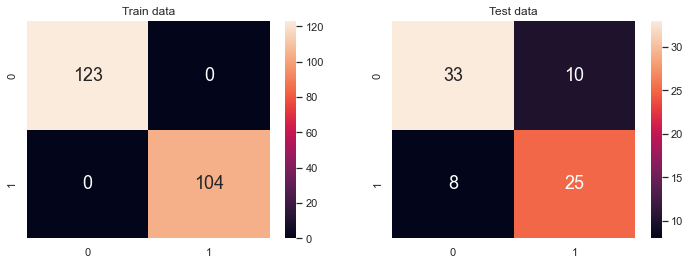

In [16]:
#Evaluation of accuracy based on confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn import metrics

y_pred = xgb_cl.predict(X_test)
y_pred_train = xgb_cl.predict(X_train)

cm_test = confusion_matrix(y_pred, y_test)
cm_train = confusion_matrix(y_pred_train, y_train)

f1_score = metrics.f1_score(y_test, y_pred)

print()
print('Accuracy for training set for XGBoost = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for XGBoost = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))
print('F1 score for test set for XGBoost: ', f1_score)
print()
print("Score: ", accuracy_score(y_test, preds))

#Plotting confusion matrices for visualisation
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
a = sb.heatmap(confusion_matrix(y_pred_train, y_train),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
b = sb.heatmap(confusion_matrix(y_pred, y_test), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
a.set_title('Train data')
b.set_title('Test data')

Even with default parameters, we got an 80% accuracy which is reasonably good. In the next sections, we will try to improve the model even further by using GridSearchCV offered by Scikit-learn.

### What Powers XGBoost Under the Hood

Unlike many other algorithms, XGBoost is an ensemble learning algorithm meaning that it combines the results of many models, called base learners to make a prediction.

Just like in Random Forests, XGBoost uses Decision Trees as base learners. However, the trees used by XGBoost are a bit different than traditional decision trees. They are called CART trees (Classification and Regression trees) and instead of containing a single decision in each “leaf” node, they contain real-value scores of whether an instance belongs to a group. After the tree reaches max depth, the decision can be made by converting the scores into categories using a certain threshold.

So far, we have been using only the default hyperparameters of the XGBoost Classifier.

### Overview of XGBoost Classifier Hyperparameters

In [17]:
xgb_cl

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

We can tune these parameters and see if they change the performance of the model.

### Hyperparameter Tuning of XGBoost with GridSearchCV

We will be using the GridSearchCV class from Scikit-learn which accepts possible values for desired hyperparameters and fits separate models on the given data for each combination of hyperparameters.

Let’s create the parameter grid for the first round:

In [18]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In the grid, I fixed subsample and colsample_bytree to recommended values to speed things up and prevent overfitting.

We will import GridSearchCV from sklearn.model_selection, instantiate and fit it to our preprocessed data:

In [19]:
from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_processed, y_processed)

[21:24:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\asus\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\asus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\asus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After an excruciatingly long time, we finally got the best params and best score:

In [20]:
grid_cv.best_score_

0.9105180700000313

This time, we chose roc_auc metric which calculates the area under the ROC (receiver operating characteristic) curve. It is one of the most popular and robust evaluation metrics for unbalanced classification problems.

In [21]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 7,
 'reg_lambda': 10,
 'scale_pos_weight': 5,
 'subsample': 0.8}

As you can see, only scale_pos_weight is in the middle of its provided range. The other parameters are at the end of their ranges meaning that we have to keep exploring:

In [22]:
# Insert the new fixed values to the grid
param_grid["scale_pos_weight"] = [3]
param_grid["subsample"] = [0.8]
param_grid["colsample_bytree"] = [0.5]

# Give new value ranges to other params
param_grid["gamma"] = [3, 5, 7]
param_grid["max_depth"] = [9, 15, 20]
param_grid["reg_lambda"] = [10, 30, 50]
param_grid["learning_rate"] = [0.3, 0.5, 0.7, 1]

We will fit a new GridSearch object to the data with the updated param grid and see if we got an improvement on the best score:

In [23]:
grid_cv_2 = GridSearchCV(xgb_cl, param_grid, 
                         cv=3, scoring="roc_auc", n_jobs=-1)

_ = grid_cv_2.fit(X_processed, y_processed)

[21:24:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\asus\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\asus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\asus\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
grid_cv_2.best_score_

0.9057267608763139

Looks like the second round of tuning resulted in a slight decrease in performance. We have got no choice but to stick with the first set of parameters which were:

In [25]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 7,
 'reg_lambda': 10,
 'scale_pos_weight': 5,
 'subsample': 0.8}

Let’s create a final classifier with the above parameters:

In [26]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective="binary:logistic"
)

In [27]:
from sklearn.metrics import roc_auc_score

_ = final_cl.fit(X_train, y_train)

preds = final_cl.predict(X_test)

[21:24:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



Accuracy for training set for XGBoost = 0.8722466960352423
Accuracy for test set for XGBoost = 0.6973684210526315
F1 score for test set for XGBoost:  0.7356321839080461

Score:  0.6973684210526315


Text(0.5, 1.0, 'Test data')

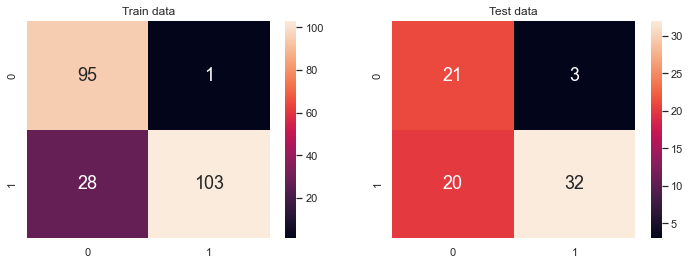

In [28]:
#Evaluation of accuracy based on confusion matrix 
y_pred = final_cl.predict(X_test)
y_pred_train = final_cl.predict(X_train)

cm_test = confusion_matrix(y_pred, y_test)
cm_train = confusion_matrix(y_pred_train, y_train)

f1_score = metrics.f1_score(y_test, y_pred)

print()
print('Accuracy for training set for XGBoost = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for XGBoost = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))
print('F1 score for test set for XGBoost: ', f1_score)
print()
print("Score: ", accuracy_score(y_test, preds))

#Plotting confusion matrices for visualisation
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
a = sb.heatmap(confusion_matrix(y_pred_train, y_train),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
b = sb.heatmap(confusion_matrix(y_pred, y_test), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
a.set_title('Train data')
b.set_title('Test data')

### Results

* Accuracy for training set for XGBoost = 0.8722466960352423
* Accuracy for test set for XGBoost = 0.6973684210526315
* Score = 0.6973684210526315
* F1 score = 0.7356321839080461

# Logistic Regression

In [29]:
# for logistic regression 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

### Logistic regression with all variables other than DIS and NUM as predictors 


Accuracy for training set for Logistic regression:  0.8722466960352423
Accuracy for test set for Logistic regression:  0.7631578947368421
F1 score for training set for Logistic Regression:  0.8599033816425121
F1 score for test set for Logistic Regression:  0.7272727272727272

Score:  0.6336633663366337


C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\asus\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Text(0.5, 1.0, 'Test data')

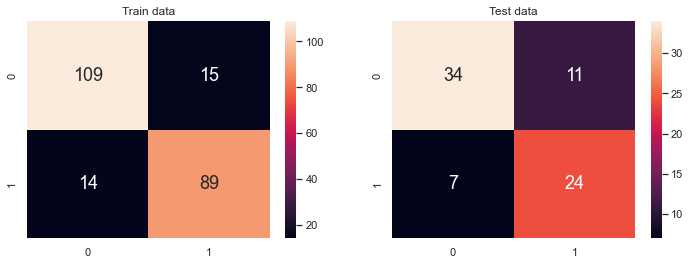

In [30]:
# split into train and test sets with where 80% of the data is used for training 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Logistic regressiom max_iter is set to 5000 because original value of 100 was insufficient for the model to converge 
logModel = LogisticRegression(max_iter = 5000, random_state = 1)
logModel.fit(X_train, y_train)

# Predicting the Test set results
y_pred = logModel.predict(X_test)

#Evaluation of accuracy based on confusion matrix 
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = logModel.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

f1_score_test = metrics.f1_score(y_test, y_pred)
f1_score_train = metrics.f1_score(y_train, y_pred_train)

print()
print('Accuracy for training set for Logistic regression: ', sklearn.metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy for test set for Logistic regression: ', sklearn.metrics.accuracy_score(y_test, y_pred))
print('F1 score for training set for Logistic Regression: ', f1_score_train)
print('F1 score for test set for Logistic Regression: ', f1_score_test)
print()
print("Score: ", logModel.score(X,y))


#Plotting confusion matrices for visualisation
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
a = sb.heatmap(confusion_matrix(y_pred_train, y_train),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
b = sb.heatmap(confusion_matrix(y_pred, y_test), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
a.set_title('Train data')
b.set_title('Test data')




### Results

* Accuracy for training set for Logistic Regression = 0.8722466960352423
* Accuracy for test set for Logistic Regression = 0.7631578947368421
* F1 score = 0.7272727272727272
* Score = 0.6336633663366337

### Grid Search on logistic regression 

Next, we used grid search to see if there is a hyperparameter combination that increases the model accuracy to a value greater than the 86.1%

In [31]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# define models and parameters
model = LogisticRegression(max_iter = 5000) #because normal 100 max_iter generated a convergence error
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga', 'sag'] #all solvers 
penalty = ['l2', 'l1', 'none', 'elasicnet'] #all penalties
c_values = [100, 10, 1.0, 0.1, 0.01] #for varying degress of regularization strengths 

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state = 1) #5 splits with 3 repeats. 

#carry out grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.860290 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}
0.836876 (0.053305) with: {'C': 100, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 1

C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
675 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\asus\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueEr

Best: 0.860290 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

Best accuracy with grid search was 0.860290 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'} combination which is worse  than the training test accuracy score using default parameters which was 0.8722466.


C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\asus\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



Accuracy for training set for Logistic Regression =  0.8810572687224669
Accuracy for test set for Logistic Regression =  0.75
F1 score for training set for Logisitc Regression:  0.8615384615384616
F1 score for test set for Logistic Regression:  0.6984126984126985

Score:  0.6039603960396039


Text(0.5, 1.0, 'Test data')

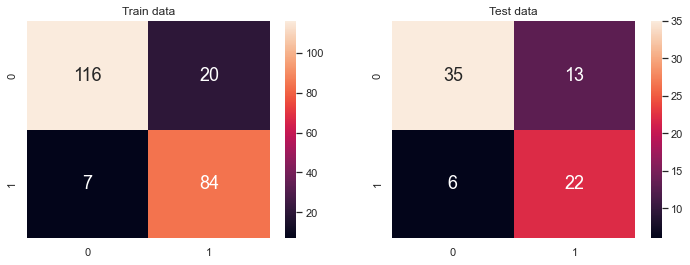

In [32]:
#Logistic regression using the new parameters from grid search 
#Logistic regressiom max_iter is set to 5000 because default value of 100 was insufficient for the model to converge 
logModel = LogisticRegression(max_iter = 5000, C = 0.01, penalty = 'l2', solver = 'newton-cg')
logModel.fit(X_train, y_train)

# Predicting the Test set results
y_pred = logModel.predict(X_test)

#Evaluation of accuracy based on confusion matrix 
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = logModel.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

f1_score_test = metrics.f1_score(y_test, y_pred)
f1_score_train = metrics.f1_score(y_train, y_pred_train)

print()
print('Accuracy for training set for Logistic Regression = ', sklearn.metrics.accuracy_score(y_train, y_pred_train))
print('Accuracy for test set for Logistic Regression = ', sklearn.metrics.accuracy_score(y_test, y_pred))
print('F1 score for training set for Logisitc Regression: ', f1_score_train)
print('F1 score for test set for Logistic Regression: ', f1_score_test)
print()
print("Score: ", logModel.score(X,y))

#Plotting confusion matrices for visualisation
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
a = sb.heatmap(confusion_matrix(y_pred_train, y_train),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
b = sb.heatmap(confusion_matrix(y_pred, y_test), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
a.set_title('Train data')
b.set_title('Test data')


# Multi-Variate Classification Tree

## Basic Exploration

### Exploring DIS

Angiographic disease status : 2
0    164
1    139
Name: DIS, dtype: int64


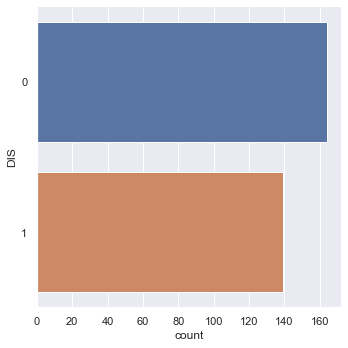

In [33]:
print("Angiographic disease status :", len(heartdata["DIS"].unique()))

print(heartdata["DIS"].value_counts())
sb.catplot(y = "DIS", data = heartdata, kind = "count")

### Checking the imbalance in data

In [34]:
count1, count0 = heartdata.DIS.value_counts()
print("Ratio of the presence and absence of heart disease 1:0 = ", count1, ":", count0)

Ratio of the presence and absence of heart disease 1:0 =  164 : 139


### Classification Tree

In [35]:
# Importing DecisionTreeClassifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 21)  # creating the decision tree object
dectree.fit(X_train, y_train)    

DecisionTreeClassifier(max_depth=21)

[Text(0.538109756097561, 0.9545454545454546, 'THAL <= -0.347\ngini = 0.496\nsamples = 227\nvalue = [123, 104]\nclass = Has heart-disease'),
 Text(0.32621951219512196, 0.8636363636363636, 'OLDPEAK <= 0.915\ngini = 0.349\nsamples = 129\nvalue = [100, 29]\nclass = Has heart-disease'),
 Text(0.23780487804878048, 0.7727272727272727, 'EXANG <= 0.369\ngini = 0.28\nsamples = 119\nvalue = [99, 20]\nclass = Has heart-disease'),
 Text(0.13414634146341464, 0.6818181818181818, 'THALCH <= -0.924\ngini = 0.17\nsamples = 96\nvalue = [87, 9]\nclass = Has heart-disease'),
 Text(0.07317073170731707, 0.5909090909090909, 'SEX <= -0.386\ngini = 0.48\nsamples = 10\nvalue = [6, 4]\nclass = Has heart-disease'),
 Text(0.04878048780487805, 0.5, 'TRESTBPS <= 0.131\ngini = 0.245\nsamples = 7\nvalue = [6, 1]\nclass = Has heart-disease'),
 Text(0.024390243902439025, 0.4090909090909091, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]\nclass = Has heart-disease'),
 Text(0.07317073170731707, 0.4090909090909091, 'gini = 0.0\ns

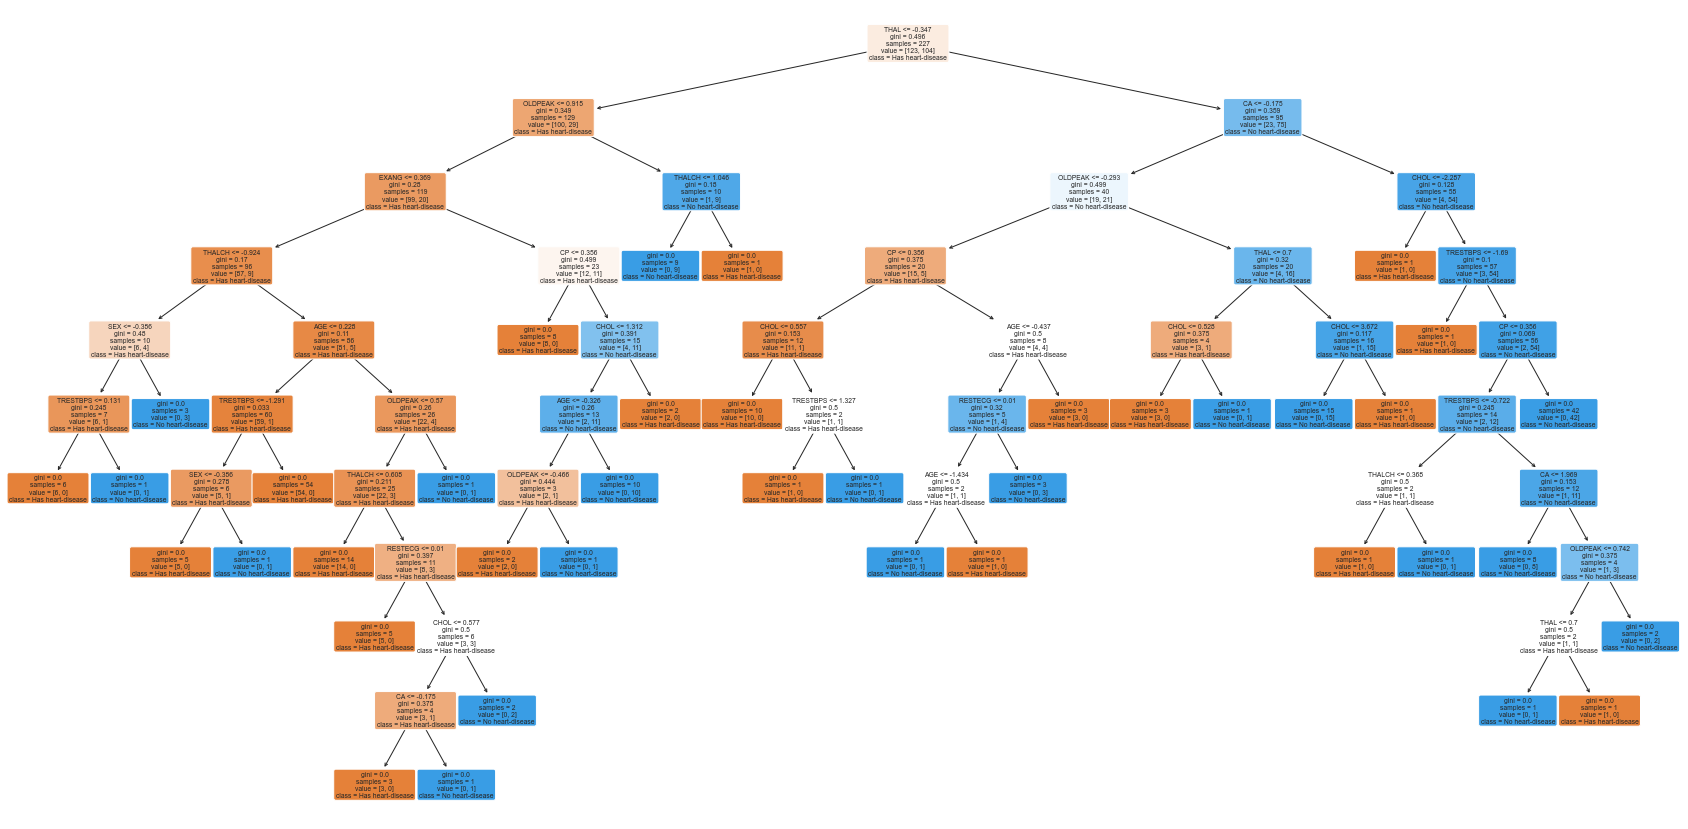

In [36]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(30,15))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X.columns, 
          class_names=["Has heart-disease","No heart-disease"])

### Checking the goodness of fit of the model


Accuracy for training set for Classification Trees = 1.0
Accuracy for test set for Classification Trees = 0.6710526315789473
F1 score for test set for Classification Trees:  0.6575342465753424

Score:  0.45874587458745875


C:\Users\asus\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Text(0.5, 1.0, 'Test data')

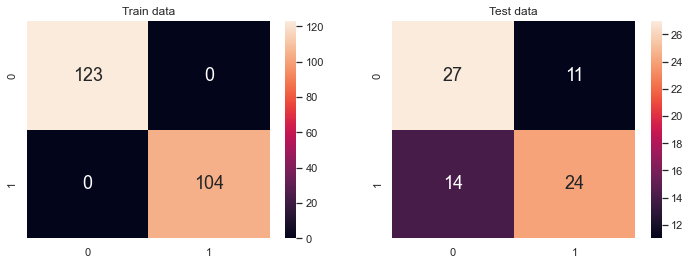

In [37]:
#Evaluation of accuracy based on confusion matrix 
y_pred = dectree.predict(X_test)
y_pred_train = dectree.predict(X_train)

cm_test = confusion_matrix(y_pred, y_test)
cm_train = confusion_matrix(y_pred_train, y_train)

f1_score = metrics.f1_score(y_test, y_pred)

print()
print('Accuracy for training set for Classification Trees = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Classification Trees = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))
print('F1 score for test set for Classification Trees: ', f1_score)
print()
print("Score: ", dectree.score(X,y))

#Plotting confusion matrices for visualisation
from sklearn.metrics import confusion_matrix
f, axes = plt.subplots(1, 2, figsize=(12, 4))
a = sb.heatmap(confusion_matrix(y_pred_train, y_train),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
b = sb.heatmap(confusion_matrix(y_pred, y_test), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
a.set_title('Train data')
b.set_title('Test data')

In [38]:
# Predict Legendary values corresponding to Total
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)
confmatrix_train_1 = confusion_matrix(y_train, y_train_pred)
confmatrix_test_1 = confusion_matrix(y_test, y_test_pred)

def measures(confusionmatrix, depth, typeofdata):
    tn,fp,fn,tp = confusionmatrix.ravel()
    TPR = tp / (tp+fn)
    TNR = tn/ (tn+fp)
    FPR = fp / (tn+fp)
    FNR = fn / (tp+fn)
    print(f'True Positive-rate for confusion matrix of depth {depth} {typeofdata} data set:', TPR)
    print(f'False Positive-rate for confusion matrix of depth {depth} {typeofdata} data set:', FPR)
    print(f'True Negative-rate for confusion matrix of depth {depth} {typeofdata} data set:', TNR)
    print(f'False Negative-rate for confusion matrix of depth {depth} {typeofdata} data set:', FNR)

measures(confmatrix_train_1, 21, 'train')
measures(confmatrix_test_1, 21, 'test')

True Positive-rate for confusion matrix of depth 21 train data set: 1.0
False Positive-rate for confusion matrix of depth 21 train data set: 0.0
True Negative-rate for confusion matrix of depth 21 train data set: 1.0
False Negative-rate for confusion matrix of depth 21 train data set: 0.0
True Positive-rate for confusion matrix of depth 21 test data set: 0.6857142857142857
False Positive-rate for confusion matrix of depth 21 test data set: 0.34146341463414637
True Negative-rate for confusion matrix of depth 21 test data set: 0.6585365853658537
False Negative-rate for confusion matrix of depth 21 test data set: 0.3142857142857143


In [39]:
#importance_DF = pd.DataFrame(dectree.feature_importances_)
#importance_DF
heartdata.drop("DIS", axis=1, inplace=True)
importance_DF = pd.DataFrame({'variable':heartdata.columns, 'importance':dectree.feature_importances_})
importance_DF

,variable,importance
0,AGE,0.054425
1,SEX,0.042167
2,CP,0.068381
3,TRESTBPS,0.048237
4,CHOL,0.088323
5,FBS,0.000000
6,RESTECG,0.017423
7,THALCH,0.051553
8,EXANG,0.048681
9,OLDPEAK,0.170858


### Results

* Accuracy for training set for Classification Trees = 1.0
* Accuracy for test set for Classification Trees = 0.6842105263157895
* Score = 0.45874587458745875
* F1 score = 0.6756756756756757